In [99]:
import sys
sys.path.append('../sgmm')
sys.path.append('../metrics')
sys.path.append('../Misc')
sys.path.append('../visual')
sys.path.append('../otherModels')
sys.path.append('../LogOdds')

In [199]:
import numpy as np
import pandas as pd
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults
from mlModels import logisticRegressionCv2, neural_nets, randomforests,\
kmeansLogRegr, xboost, gradboost,kmeansBNB
from sklearn.naive_bayes import BernoulliNB
from supervisedBmm import SupervisedBMM
from utility import entropy,asymm_entropy
from ftest_logodds import ftest_uncorr
from ftest_logodds import restest
from clustmap import plotclustmap

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/SPARCS_Subsets/Obsolete/sparcs25%Newborn_DeHos_Outflow_Region.csv") 

d_newborn_tr, d_newborn_te = train_test_split(sparcs, test_size=0.2, random_state = 1512)

print(d_newborn_tr.shape[0], d_newborn_tr.shape[1])

93543 260


In [5]:
# metric matrix columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

In [6]:
# feature list
features = list(sparcs.iloc[:,:-1])

In [7]:
#Preparing the data
Xtrain, Xtest = d_newborn_tr.iloc[:,0:-1].values, d_newborn_te.iloc[:,0:-1].values
ytrain, ytest = d_newborn_tr.iloc[:,-1].values.astype(int), d_newborn_te.iloc[:,-1].values.astype(int)

In [ ]:
#VALIDATION ON CLUSTERS
#RUN VALIDATION ON NUMBER OF CLUSTERS BASED ON AUC & F1

import time

train, val = train_test_split(d_newborn_tr, test_size = 0.2, random_state = 1512)
y_train, y_val = train.iloc[:,-1], val.iloc[:,-1]

print( train.shape, val.shape )

#SET SGMM PARAMETERS

max_iter = 30
max_iter2 = 10

train_np = train.iloc[:,0:-1].values
val_np = val.iloc[:,0:-1].values

y_train_np = y_train.values
y_val_np = y_val.values

test_re = []
train_re = []

start = time.time()

#test clusters 2-10
for i in range(2,11):
    print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
    np.random.seed( seed = 100 )
    model = SupervisedGMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i)
    model = model.fit(Xtrain = train_np, ytrain = y_train_np)
    probTrain = model.predict_proba( train_np )
    probTest = model.predict_proba( val_np )
    results = sgmmResults( model, probTest.copy(), probTrain.copy(), y_val_np.copy(), y_train_np.copy(), tau = None,
                mode = 0)
    testmetrics = results['testMet']
    trainMetrics = results[ 'trainMet']
    test_re.append( testmetrics )
    train_re.append( trainMetrics )
    
end = time.time() - start
print("time elapsed: {}".format( end ))

(74834, 260) (18709, 260)



TRAINING WITH 2 CLUSTERS
GMM iteration: 0, error: 0.455167132422938
GMM iteration: 1, error: 0.13873319803578602
GMM iteration: 2, error: 0.03182833793555198
GMM iteration: 3, error: 0.00787495554461224
GMM iteration: 4, error: 0.003185408201765444
GMM iteration: 5, error: 0.0006509403279934112



TRAINING WITH 3 CLUSTERS
GMM iteration: 0, error: 0.2728288432708714
GMM iteration: 1, error: 0.2804415663497195
GMM iteration: 2, error: 0.08218731702691644
GMM iteration: 3, error: 0.01779133964535167
GMM iteration: 4, error: 0.003653854329353966
GMM iteration: 5, error: 0.0007750420717540521



TRAINING WITH 4 CLUSTERS
GMM iteration: 0, error: 0.3684373055170939
GMM iteration: 1, error: 0.08322067087740727
GMM iteration: 2, error: 0.019232580047749376
GMM iteration: 3, error: 0.005310165079457266
GMM iteration: 4, error: 0.0011237686697387638
GMM iteration: 5, error: 0.00025886997559348545



TRAINING WITH 5 CLUSTERS
GMM iteration: 0, error: 0.24107729798422606

In [123]:
#PICK THE CLUSTERS

columns = test_re[0].columns
pdi = pd.DataFrame(np.zeros(shape = [len(test_re), test_re[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re), train_re[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['cluster']= pd.DataFrame(np.arange(2,11))
pdi.round(3)

#BASED ON auc and F1, WE PICK 5 CLUSTERS, although these values tend not to vary a lot.


,cluster,size,high_cost%,low_cost%,TP,TN,FP,FN,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,2,18709.0,0.253,0.747,3185.0,10745.0,3239.0,1540.0,0.232,0.768,0.674,0.496,0.745,0.721,0.571,0.812
1,3,18709.0,0.253,0.747,3227.0,10662.0,3322.0,1498.0,0.238,0.762,0.683,0.493,0.742,0.723,0.572,0.813
2,4,18709.0,0.253,0.747,3204.0,10689.0,3295.0,1521.0,0.236,0.764,0.678,0.493,0.743,0.721,0.571,0.809
3,5,18709.0,0.253,0.747,3320.0,10446.0,3538.0,1405.0,0.253,0.747,0.703,0.484,0.736,0.725,0.573,0.813
4,6,18709.0,0.253,0.747,3203.0,10697.0,3287.0,1522.0,0.235,0.765,0.678,0.494,0.743,0.721,0.571,0.811
5,7,18709.0,0.253,0.747,3286.0,10457.0,3527.0,1439.0,0.252,0.748,0.695,0.482,0.735,0.722,0.570,0.809
6,8,18709.0,0.253,0.747,3239.0,10650.0,3334.0,1486.0,0.238,0.762,0.686,0.493,0.742,0.724,0.573,0.813
7,9,18709.0,0.253,0.747,3196.0,10704.0,3280.0,1529.0,0.235,0.765,0.676,0.494,0.743,0.721,0.571,0.812


In [18]:
# similarly for SBMM

#SET SBMM PARAMETERS

max_iter = 30
max_iter2 = 10

test_re_B = []
train_re_B = []

start = time.time()

#test clusters 2-10
for i in range(2,11):
    print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
    np.random.seed( seed = 100)
    modelB = SupervisedBMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i)
    modelB = modelB.fitB(Xtrain = train_np, Xtest=val_np, ytrain = y_train_np)

    logisRegre = modelB.LogRegr
    fitP = modelB.fitParams
    labTrainB  = fitP['labTrain']
    mTest = modelB.predict_BMMS(val_np)
    labTestB = np.argmax( mTest, axis = 1 )

    probTest, probTrain = modelB.predict_prob_int_B( Xtest = val_np, Xtrain = train_np )
    tau = optimalTau(probTrain, y_train_np)
    metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = y_val_np)
    metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = y_train_np)
    metTestSBMM = pd.DataFrame( [metTest], columns = columns)
    metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)
    
    test_re_B.append( metTestSBMM )
    train_re_B.append( metTrainSBMM )
    
end = time.time() - start
print("time elapsed: {}".format( end ))




TRAINING WITH 2 CLUSTERS
BMM iteration: 0, error: 0.1932407548112186
BMM iteration: 1, error: 0.040789991727124414
BMM iteration: 2, error: 0.032911214790080794
BMM iteration: 3, error: 0.08046415673058717
BMM iteration: 4, error: 0.15831959232990778
BMM iteration: 5, error: 0.18410622599872686
BMM iteration: 6, error: 0.11095940070693265
BMM iteration: 7, error: 0.04002958909382674
BMM iteration: 8, error: 0.009837091179673055
BMM iteration: 9, error: 0.0022414263295564467



TRAINING WITH 3 CLUSTERS
BMM iteration: 0, error: 0.14345335089245217
BMM iteration: 1, error: 0.030109608791185134
BMM iteration: 2, error: 0.020662181606175282
BMM iteration: 3, error: 0.04696971290923645
BMM iteration: 4, error: 0.09522645038964675
BMM iteration: 5, error: 0.14941608427356887
BMM iteration: 6, error: 0.12352547356362424
BMM iteration: 7, error: 0.06853556939334922
BMM iteration: 8, error: 0.03417206989001568
BMM iteration: 9, error: 0.01940107805076086



TRAINING WITH 4 CLUSTERS
BMM iterat

In [122]:
#PICK THE CLUSTERS

pdi = pd.DataFrame(np.zeros(shape = [len(test_re_B), test_re_B[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re_B), train_re_B[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re_B):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re_B):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['cluster']= pd.DataFrame(np.arange(2,11))        
pdi.round(3)

#BASED ON THAT WE PICK 8 CLUSTERS


,cluster,size,high_cost%,low_cost%,TP,TN,FP,FN,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,2,18709.0,0.253,0.747,3358.0,10365.0,3619.0,1367.0,0.259,0.741,0.711,0.481,0.733,0.726,0.574,0.816
1,3,18709.0,0.253,0.747,3036.0,11170.0,2814.0,1689.0,0.201,0.799,0.643,0.519,0.759,0.721,0.574,0.817
2,4,18709.0,0.253,0.747,3271.0,10580.0,3404.0,1454.0,0.243,0.757,0.692,0.490,0.740,0.724,0.574,0.817
3,5,18709.0,0.253,0.747,3241.0,10531.0,3453.0,1484.0,0.247,0.753,0.686,0.484,0.736,0.720,0.568,0.812
4,6,18709.0,0.253,0.747,3072.0,11105.0,2879.0,1653.0,0.206,0.794,0.650,0.516,0.758,0.722,0.575,0.815
5,7,18709.0,0.253,0.747,3307.0,10487.0,3497.0,1418.0,0.250,0.750,0.700,0.486,0.737,0.725,0.574,0.807
6,8,18709.0,0.253,0.747,2711.0,12005.0,1979.0,2014.0,0.142,0.858,0.574,0.578,0.787,0.716,0.576,0.817
7,9,18709.0,0.253,0.747,2778.0,11797.0,2187.0,1947.0,0.156,0.844,0.588,0.560,0.779,0.716,0.573,0.815
8,10,18709.0,0.253,0.747,2763.0,11786.0,2198.0,1962.0,0.157,0.843,0.585,0.557,0.778,0.714,0.571,0.805


# Nonclustering Classification

In [20]:
# Fitting a Bernoulli Naive Bayes
bnb = BernoulliNB(alpha= 1,class_prior=[0.75,0.25])
bnb.fit(Xtrain, ytrain)
probTrainNB,probTestNB = bnb.predict_proba(Xtrain)[:,1], bnb.predict_proba(Xtest)[:,1]
tau = optimalTau(probTrainNB, ytrain)
metTest,_ = calc_metrics(custom_prob = probTestNB.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNB.copy(), tau = tau, y = ytrain)
metTestNB = pd.DataFrame( [metTest], columns = columns)
metTrainNB = pd.DataFrame( [metTrain], columns = columns)

In [21]:
#FITTING L1 LOGISTIC REGRESSION
Cs = [1,10,100,1000]
pL1, probTestL1, probTrainL1 = logisticRegressionCv2( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest, Cs = Cs )
tau = optimalTau(probTrainL1, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestL1.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainL1.copy(), tau = tau, y = ytrain)
metTestL1 = pd.DataFrame( [metTest], columns = columns)
metTrainL1 = pd.DataFrame( [metTrain], columns = columns)

In [22]:
#Fitting Neural Nets
pNN, probTestNN, probTrainNN = neural_nets( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest,
                                                  h_l_s = (4 ,4, 2))
tau = optimalTau(probTrainNN, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestNN.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNN.copy(), tau = tau, y = ytrain)
metTestNN = pd.DataFrame( [metTest], columns = columns)
metTrainNN = pd.DataFrame( [metTrain], columns = columns)

In [23]:
#RANDOM FORESTS
params, probTest, probTrain = randomforests(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestRF = pd.DataFrame( [metTest], columns = columns)
metTrainRF = pd.DataFrame( [metTrain], columns = columns)


In [24]:
#Ada boost
params, probTest, probTrain = xboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestXB = pd.DataFrame( [metTest], columns = columns)
metTrainXB = pd.DataFrame( [metTrain], columns = columns)

In [25]:
#Grad boost
params, probTest, probTrain = gradboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestGB = pd.DataFrame( [metTest], columns = columns)
metTrainGB = pd.DataFrame( [metTrain], columns = columns)

# Sequential clustering + classification

In [26]:
np.random.seed( seed = 100)
#Kmeans + LG
n_clusters = 5
Cs = [1,10,100,1000]
kmeansParams = kmeansLogRegr(Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, Cs = Cs, n_clusters = n_clusters)

modelsKM = kmeansParams['models']
labTrKM, labTestKM  = kmeansParams['labelsTrain'], kmeansParams['labelsTest']


# KMS class accuracy
metTrainKMc, metTestKMc = metrics_cluster(models = modelsKM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKM,
                                        trainlabels = labTrKM,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [27]:
# KMS LG overall accuaracy
probTr= np.array([])
for i in range(len(kmeansParams['probTrain'])):
    probTr = np.append(probTr,kmeansParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKM==i])

probTe= np.array([])
for i in range(len(kmeansParams['probTest'])):
    probTe = np.append(probTe,kmeansParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKM==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMS = pd.DataFrame( [metTrain], columns = columns)
metTestKMS = pd.DataFrame( [metTest], columns = columns)

In [31]:
np.random.seed( seed = 100)
# kmeans + NB classifier
n_clusters = 5

kmeansNBParams = kmeansBNB( Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, n_clusters = n_clusters)
modelsKMNB = kmeansNBParams['models']
labTrKMNB, labTestKMNB  = kmeansNBParams['labelsTrain'], kmeansNBParams['labelsTest']


# KMS class accuracy
metTrainKMcNB, metTestKMcNB = metrics_cluster(models = modelsKMNB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKMNB,
                                        trainlabels = labTrKMNB,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [32]:
# KMS + NB overall accuaracy
probTr= np.array([])
for i in range(len(kmeansNBParams['probTrain'])):
    probTr = np.append(probTr,kmeansNBParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKMNB==i])

probTe= np.array([])
for i in range(len(kmeansNBParams['probTest'])):
    probTe = np.append(probTe,kmeansNBParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKMNB==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMSNB = pd.DataFrame( [metTrain], columns = columns)
metTestKMSNB = pd.DataFrame( [metTest], columns = columns)

In [173]:
np.random.seed( seed = 100)
# GMM + Classification (LG) (simple = 1)

max_iter = 30
max_iter2 = 10
n_clusters = 5

model = SupervisedGMM( max_iter = max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain, simple = 1, kmeans = 1)
# Retrieve memberships and labels
mTrainGMMLG = model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain  = fitP['labTrain']
mTestGMMLG = model.predict_GMMS(Xtest)
labTest = np.argmax( mTest, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestGMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainGMMLG = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainGMMLGc, metTestGMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)



GMM iteration: 0, error: 0.040624254074085604
GMM iteration: 1, error: 0.009807258013103516
GMM iteration: 2, error: 0.00243098865120252
GMM iteration: 3, error: 0.0007261172559695954


In [174]:
np.random.seed( seed = 100)
# BMM + Classification (LG)
max_iter = 30
max_iter2 = 10
n_clusters = 5

modelB = SupervisedBMM( n_clusters = n_clusters,max_iter = max_iter,max_iter2 = max_iter2)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain,simple=1)

mTrainBMMLG = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrain  = fitP['labTrain']
mTestBMMLG = modelB.predict_BMMS(Xtest)
labTest = np.argmax( mTest, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestBMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainBMMLG = pd.DataFrame( [metTrain], columns = columns)

metTrainBMMLGc, metTestBMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)


BMM iteration: 0, error: 0.09252981863719631
BMM iteration: 1, error: 0.01946894156648586
BMM iteration: 2, error: 0.015341310078372862
BMM iteration: 3, error: 0.03801259420461219
BMM iteration: 4, error: 0.07783472124410921
BMM iteration: 5, error: 0.09952195556395321
BMM iteration: 6, error: 0.08527792251512009
BMM iteration: 7, error: 0.05619648940105859
BMM iteration: 8, error: 0.030588641830259316
BMM iteration: 9, error: 0.018986591857874897


In [175]:
np.random.seed( seed = 100)
# train SGMM model with Log Regression
max_iter = 30
max_iter2 = 10
n_clusters = 5

model = SupervisedGMM(max_iter=max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain)

# Retrieve memberships and labels
mTrainSGMM = model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain  = fitP['labTrain']
mTestSGMM = model.predict_GMMS(Xtest)
labTest = np.argmax( mTest, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSGMM = pd.DataFrame( [metTest], columns = columns)
metTrainSGMM = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainSGc, metTestSGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)

GMM iteration: 0, error: 0.3181108015380925
GMM iteration: 1, error: 0.06594947032994039
GMM iteration: 2, error: 0.013786506104088032
GMM iteration: 3, error: 0.002921108473549236
GMM iteration: 4, error: 0.0007285647464739258


In [177]:
np.random.seed( seed = 100)

# train SBMM model with Log Regression
max_iter = 30
max_iter2 = 10
n_clusters = 5

modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2,verbose =0)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrainSBMM = modelB.mTrain
logisRegreB = modelB.LogRegr
fitPB = modelB.fitParams
labTrainB  = fitPB['labTrain']
mTestSBMM = modelB.predict_BMMS(Xtest)
labTestB = np.argmax( mTestB, axis = 1 )

probTestB, probTrainB = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tauB = optimalTau(probTrainB, ytrain)
metTestB,_ = calc_metrics(custom_prob = probTestB.copy(), tau = tauB, y = ytest)
metTrainB ,_= calc_metrics(custom_prob = probTrainB.copy(), tau = tauB, y = ytrain)
metTestSBMM = pd.DataFrame( [metTestB], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrainB], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegreB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestB,
                                        trainlabels = labTrainB,
                                        Xtrain = Xtrain, Xtest = Xtest)

BMM iteration: 0, error: 0.09250791638136636
BMM iteration: 1, error: 0.01949200145382233
BMM iteration: 2, error: 0.01546078316463198
BMM iteration: 3, error: 0.03832069458067216
BMM iteration: 4, error: 0.0788465938180783
BMM iteration: 5, error: 0.10019499708291514
BMM iteration: 6, error: 0.08491673438458869
BMM iteration: 7, error: 0.05452944619196319
BMM iteration: 8, error: 0.02906175633930771
BMM iteration: 9, error: 0.017842419613465672


# Overall predition accuracy

In [50]:
# Comparison acucuracy with other methods
trainmet = pd.concat([metTrainNB, metTrainL1,metTrainNN,metTrainRF,metTrainXB,metTrainGB, metTrainKMS,metTrainKMSNB,metTrainGMMLG,metTrainBMMLG,metTrainSGMM,metTrainSBMM],ignore_index=True)
testmet = pd.concat([metTestNB, metTestL1,metTestNN,metTestRF,metTestXB,metTestGB, metTestKMS,metTestKMSNB,metTestGMMLG,metTestBMMLG,metTestSGMM,metTestSBMM],ignore_index=True)
method = ['Naive Bayes','L1 Log Reg','Neural Network','Random Forest','AdaBoost','GradBoost','KMS + Log Reg','KMS + NB', 'GMM + Log Reg', 'BMM + Log Reg', 'SGMM w/ Log Reg', 'SBMM w/ Log Reg']
trainmet.insert(8,'method',method)
testmet.insert(8,'method',method)

In [127]:
print( 'Overall prediction accuracy')
testmet.iloc[:,8:].round(2)

Overall prediction accuracy


,method,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,Naive Bayes,0.19,0.81,0.58,0.50,0.75,0.70,0.54,0.78
1,L1 Log Reg,0.26,0.74,0.70,0.47,0.73,0.72,0.56,0.81
2,Neural Network,0.17,0.83,0.61,0.54,0.77,0.72,0.57,0.82
3,Random Forest,0.16,0.84,0.61,0.55,0.78,0.72,0.58,0.82
4,AdaBoost,0.24,0.76,0.65,0.48,0.73,0.71,0.55,0.78
5,GradBoost,0.25,0.75,0.69,0.47,0.73,0.72,0.56,0.80
6,KMS + Log Reg,0.25,0.75,0.69,0.48,0.74,0.72,0.56,0.81
7,KMS + NB,0.25,0.75,0.65,0.47,0.73,0.70,0.54,0.79
8,GMM + Log Reg,0.23,0.77,0.67,0.49,0.74,0.72,0.56,0.81
9,BMM + Log Reg,0.20,0.80,0.63,0.51,0.76,0.71,0.56,0.81


# Cadre wise prediction accuracy

In [139]:
print('Kmeans + LG')
print(metTestKMc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('Kmeans + NB')
print(metTestKMcNB.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('GMM + LG')
print(metTestGMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('BMM + LG')
print(metTestBMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('SGMM w/ LG')
print(metTestSGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('SBMM w/ LG')
print(metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])

Kmeans + LG
     size  high_cost%    f1   auc
0  4555.0        0.17  0.60  0.88
1  4252.0        0.19  0.61  0.87
2  5635.0        0.27  0.54  0.74
3  3526.0        0.29  0.58  0.78
4  5418.0        0.31  0.55  0.74
Kmeans + NB
     size  high_cost%    f1   auc
0  4555.0        0.17  0.57  0.86
1  4252.0        0.19  0.57  0.86
2  5635.0        0.27  0.51  0.73
3  3526.0        0.29  0.56  0.77
4  5418.0        0.31  0.54  0.73
GMM + LG
     size  high_cost%    f1   auc
0  3761.0        0.17  0.63  0.91
1  3976.0        0.19  0.67  0.90
2  3755.0        0.26  0.53  0.78
3  6522.0        0.27  0.53  0.74
4  5372.0        0.31  0.54  0.72
BMM + LG
     size  high_cost%    f1   auc
0  5685.0        0.12  0.54  0.84
1  2573.0        0.25  0.58  0.83
2  6366.0        0.28  0.52  0.74
3  6526.0        0.30  0.55  0.75
4  2236.0        0.34  0.66  0.83
SGMM w/ LG
      size  high_cost%    f1   auc
0  22471.0        0.24  0.55  0.80
1    336.0        0.25  0.87  0.99
2    224.0        0.33  0.

# Stratification

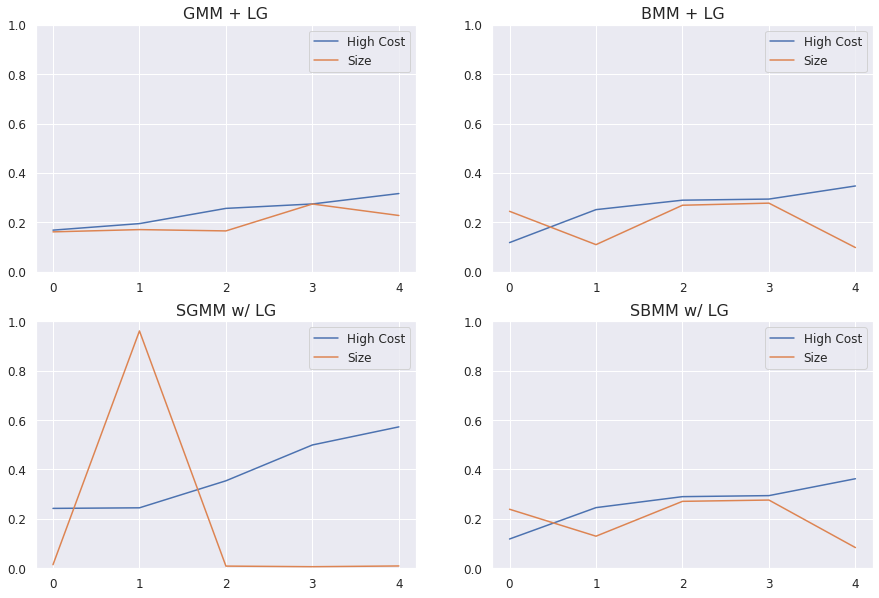

In [157]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y=sorted(metTrainGMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y= metTrainGMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('GMM + LG',fontsize=16)
plt.xticks(range(5),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 2)
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y=sorted(metTrainBMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y= metTrainBMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('BMM + LG',fontsize=16)
plt.xticks(range(5),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)


plt.subplot(2, 2, 3)
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y=sorted(metTrainSGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y= metTrainSGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SGMM w/ LG',fontsize=16)
plt.xticks(range(5),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 4)
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(5),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.show()

# Class entropy by stratification

In [202]:
# calculate cadre entropy
class_prior = d_newborn_tr['Target'].value_counts(normalize=True)[1]
entropyKMSLG,_,_= asymm_entropy(metTrainKMc.sort_values(by ='high_cost%')['high_cost%'],metTrainKMc.sort_values(by ='high_cost%')['size'],class_prior)
print('Average asymmetric cadre entropy of KMS + LG is :{}' .format(entropyKMSLG))
entropyGMMLG,_,_= asymm_entropy(metTrainGMMLGc.sort_values(by ='high_cost%')['high_cost%'],metTrainGMMLGc.sort_values(by ='high_cost%')['size'],class_prior)
print ('Average asymmetric cadre entropy of GMM+ LG is :{} '.format( entropyGMMLG ))
entropyBMMLG,_,_= asymm_entropy(metTrainBMMLGc.sort_values(by ='high_cost%')['high_cost%'],metTrainBMMLGc.sort_values(by ='high_cost%')['size'],0.25)
print ('Average asymmetric cadre entropy of BMM+ LG is :{} '.format (entropyBMMLG) )
entropySGMMLG,_, _ = asymm_entropy(metTrainSGc.sort_values(by ='high_cost%')['high_cost%'],metTrainSGc.sort_values(by ='high_cost%')['size'],0.25)
print ('Average asymmetric cadre entropy of SGMM w/ LG is :{} '.format (entropySGMMLG) )
entropySBMMLG,_,_= asymm_entropy(metTrainSBc.sort_values(by ='high_cost%')['high_cost%'],metTrainSBc.sort_values(by ='high_cost%')['size'],class_prior)
print ('Average asymmetric cadre entropy of SBMM w/ LG is :{} '.format (entropySBMMLG) )

Average asymmetric cadre entropy of KMS + LG is :0.9838051603174233
Average asymmetric cadre entropy of GMM+ LG is :0.9824438754887656 
Average asymmetric cadre entropy of BMM+ LG is :0.959982466959622 
Average asymmetric cadre entropy of SGMM w/ LG is :0.8914506659098074 
Average asymmetric cadre entropy of SBMM w/ LG is :0.9578040362438436 


# Cadre Assigment confidence 

In [179]:
# conditional entropy for each method
condEntropyGMMLG = entropy(mTrainGMMLG[:,np.argsort(metTrainGMMLGc['high_cost%'])],n_clusters)
condEntropyBMMLG = entropy(mTrainBMMLG[:,np.argsort(metTrainBMMLGc['high_cost%'])],n_clusters)
condEntropySGMM = entropy(mTrainSGMM[:,np.argsort(metTrainSGc['high_cost%'])],n_clusters)
condEntropySBMM = entropy(mTrainSBMM[:,np.argsort(metTrainSBc['high_cost%'])],n_clusters)
print('GMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyGMMLG)))
print('BMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyBMMLG)))
print('SGMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySGMM)))
print('SBMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySBMM)))

GMM + LG average conditional entropy for each cadre is  0.006619209560280573
BMM  + LG average conditional entropy for each cadre is  0.5393890888812771
SGMM w/ LG average conditional entropy for each cadre is  0.03997348910640626
SBMM w/ LG average conditional entropy for each cadre is  0.5780384689542699


In [224]:
# conditional entropy for each cluster
print('GMM + LG conditional entropy for each cadre is  {}'.format(condEntropyGMMLG))
print('BMM + LG conditional entropy for each cadre is  {}'.format(condEntropyBMMLG))
print('SGMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySGMM))
print('SBMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySBMM))

GMM + LG conditional entropy for each cadre is  [0.00323107 0.0060187  0.01615063 0.00579173 0.00190392]
BMM + LG conditional entropy for each cadre is  [0.4725646  0.61497873 0.47683704 0.50990939 0.62265568]
SGMM w/ LG conditional entropy for each cadre is  [0.07045067 0.00434737 0.03235754 0.04184573 0.05086613]
SBMM w/ LG conditional entropy for each cadre is  [0.48750511 0.68795941 0.48584143 0.49983736 0.72904903]


# Interpretability: SGMM

In [208]:
#just change the order of labels so that cost for each cluster goes from low to high

Labels = labTrain

target = pd.DataFrame(ytrain,columns=['Target'])

cadre = pd.DataFrame(Labels,columns=['Cadre'])

target['Cadre']= cadre['Cadre']

highcostratio = np.array([])
clustpop = np.array([])

for i in range(n_clusters):
    pop = target[target['Cadre']==i]['Target'].shape[0]
    clustpop = np.append(clustpop,pop)
    ratio = np.count_nonzero(target[target['Cadre']==i]['Target'].values)*1.0/pop
    highcostratio= np.append(highcostratio,ratio)
    print(pop,ratio)

1361 0.24246877296105804
89862 0.24478645033495805
833 0.35414165666266506
884 0.5723981900452488
603 0.49917081260364843


In [209]:
print('percent of high cost ratio by SGMM')
print(np.sort(highcostratio).round(2))
print('relative cadre size by SGMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print('Log odds ratio for each cadre by SGMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

percent of high cost ratio by SGMM
[0.24 0.24 0.35 0.5  0.57]
relative cadre size by SGMM
[0.015 0.961 0.009 0.006 0.009]
Log odds ratio for each cadre by SGMM
[-0.04 -0.68  0.5   1.1   1.41]


In [210]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2   

In [211]:
# Calculate log odds ratios for feature vs. target (whether or not is high cost)
target_binary = d_newborn_tr.iloc[:,-1]
data = d_newborn_tr.iloc[:,:-1]
np_feat = np.asarray(features)
labs_binary = np.expand_dims(target_binary,axis=1)
feat_table_binary,lor_table_binary =ftest_uncorr(data,labs_binary,np_feat)

In [212]:
# just show log odds ratio for race and ethnicity features : 0 lowcost, 1 high cost
pd.DataFrame(lor_table_binary[:,61:69],columns = features[61:69]).round(2)

,Black_African_American,Multi_racial,Other_Race,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity
0,-0.14,-0.59,-0.33,0.54,-0.83,-0.05,-0.06,0.33
1,0.14,0.59,0.33,-0.54,0.83,0.05,0.06,-0.33


In [213]:
# Calculate log odds ratios for feature vs. cadre 
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

In [214]:
# reduce feature length
new_feat = [s.replace('CCS_DX_' , '') for s in features]
new_feat = [s.replace('CCS_PROC_' , '') for s in new_feat]
new_feat = [s.replace('not_mental_disorders_or_infectious_disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually_transmitted_disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]
#new_feat = [s.replace('Other','Ot')for s in new_feat]
#new_feat = [s.replace('OTHER','OT')for s in new_feat]

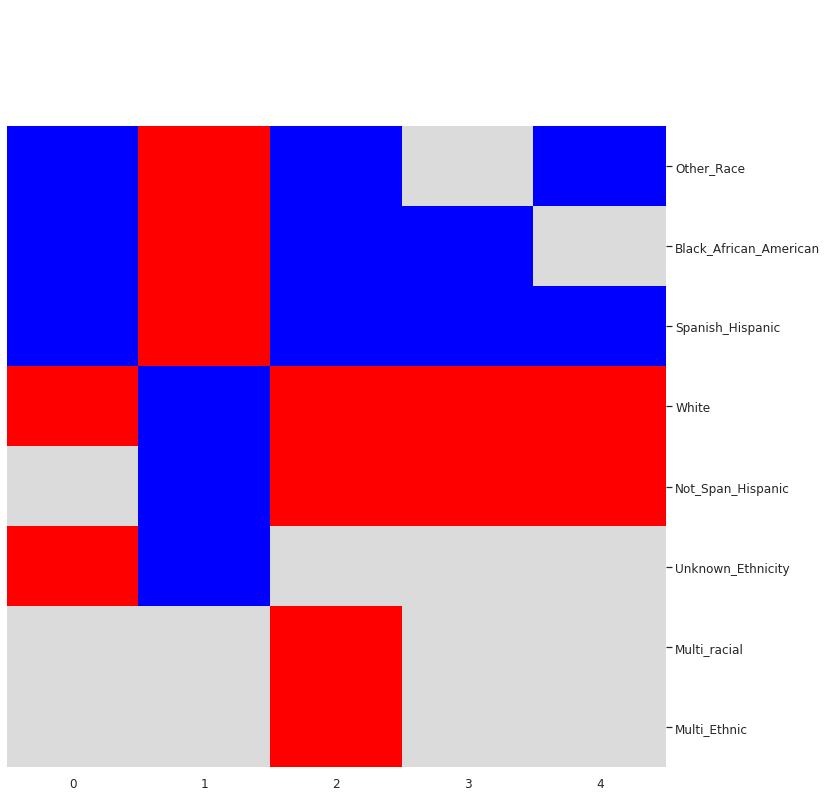

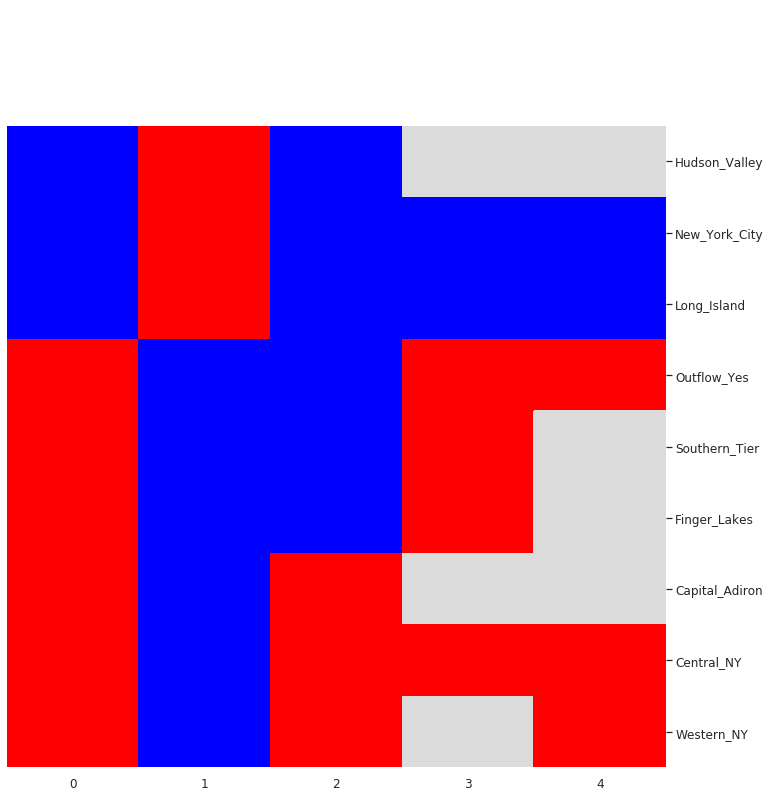

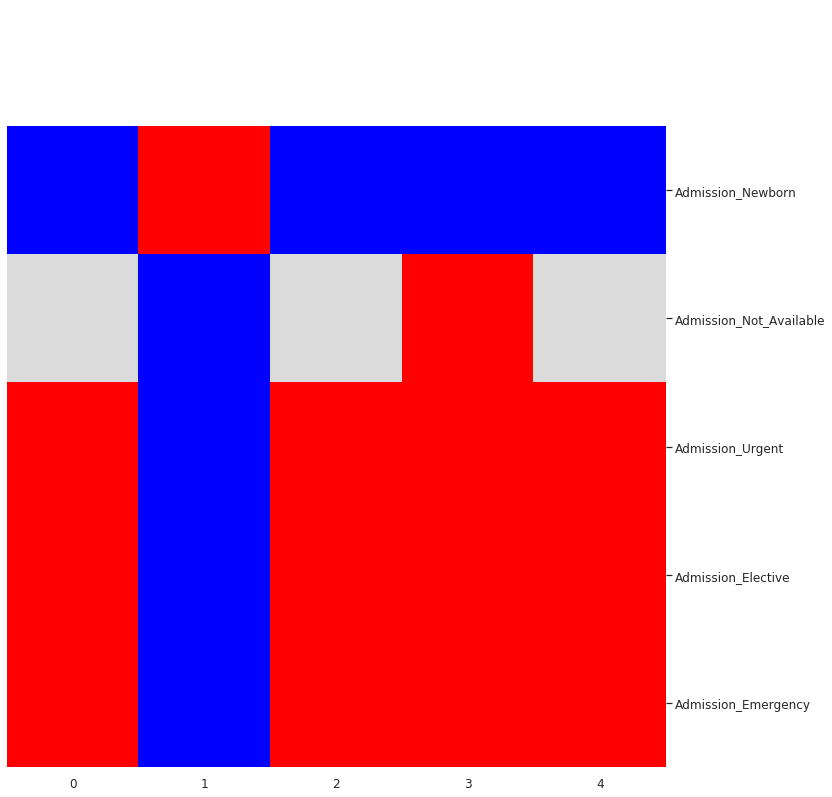

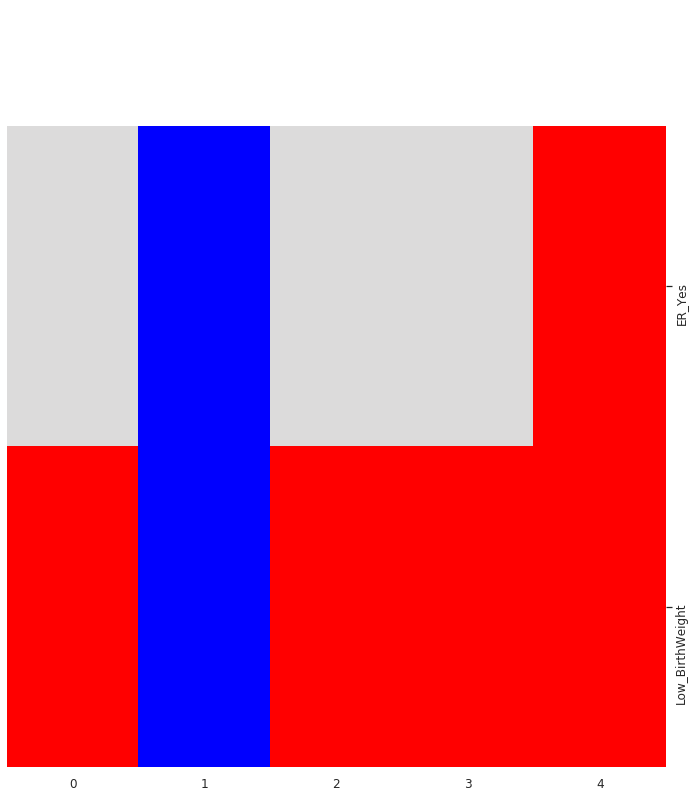

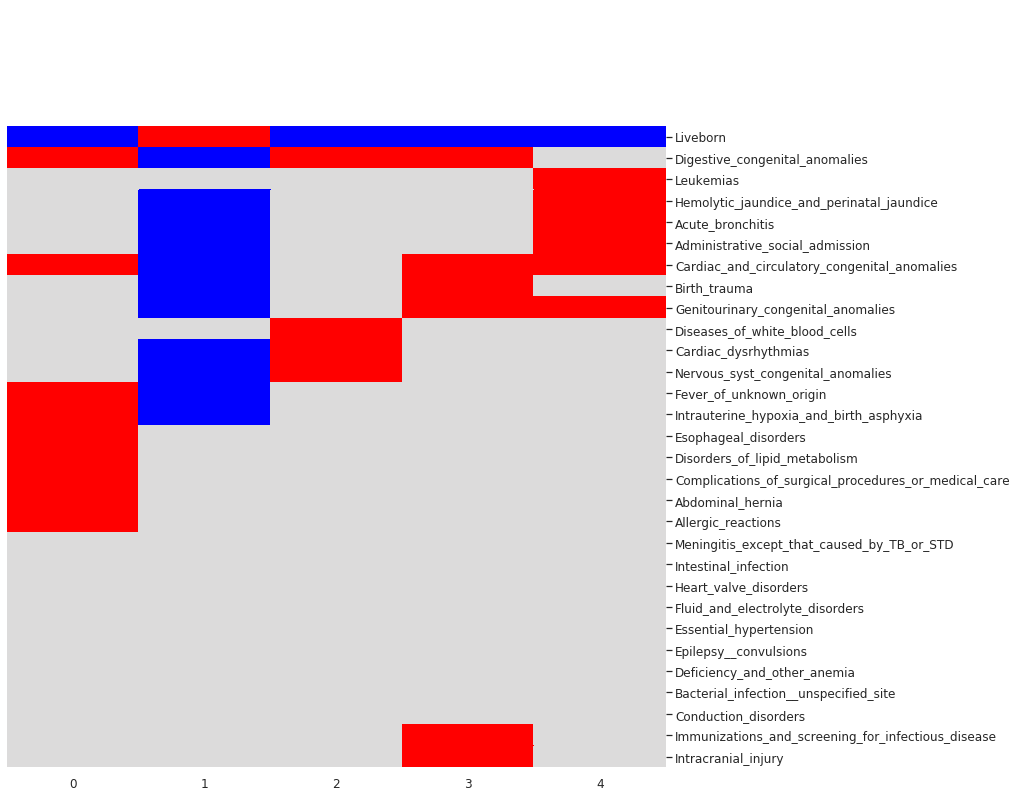

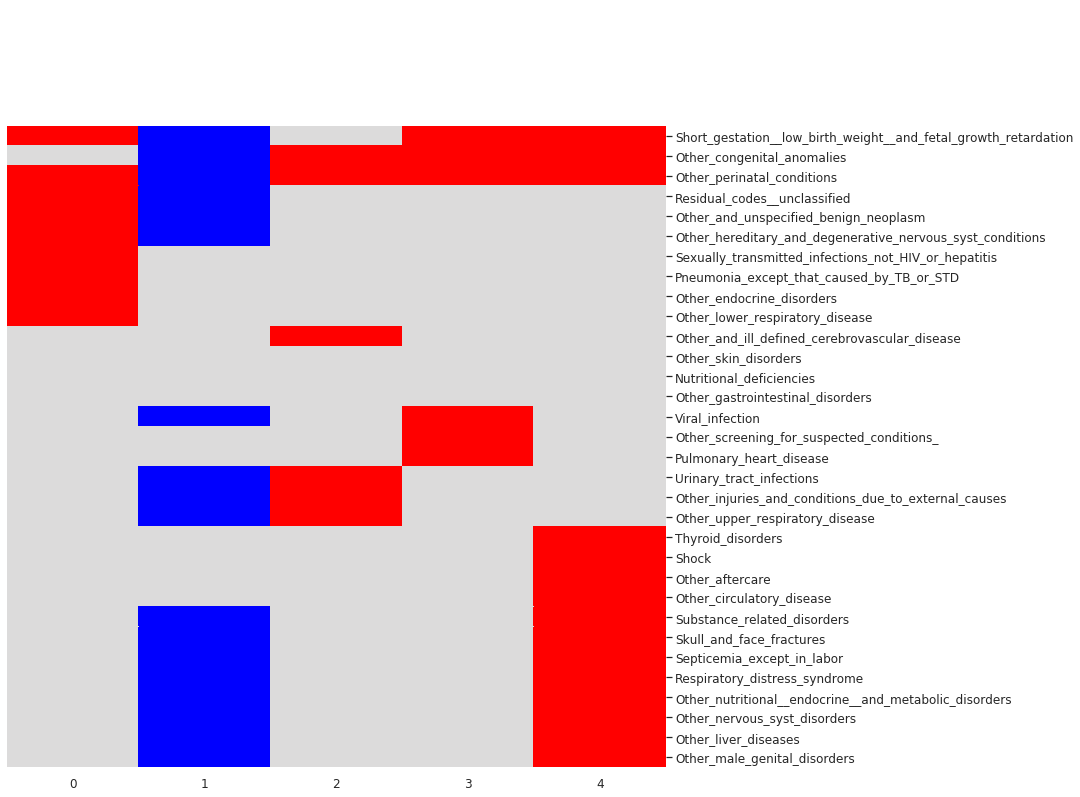

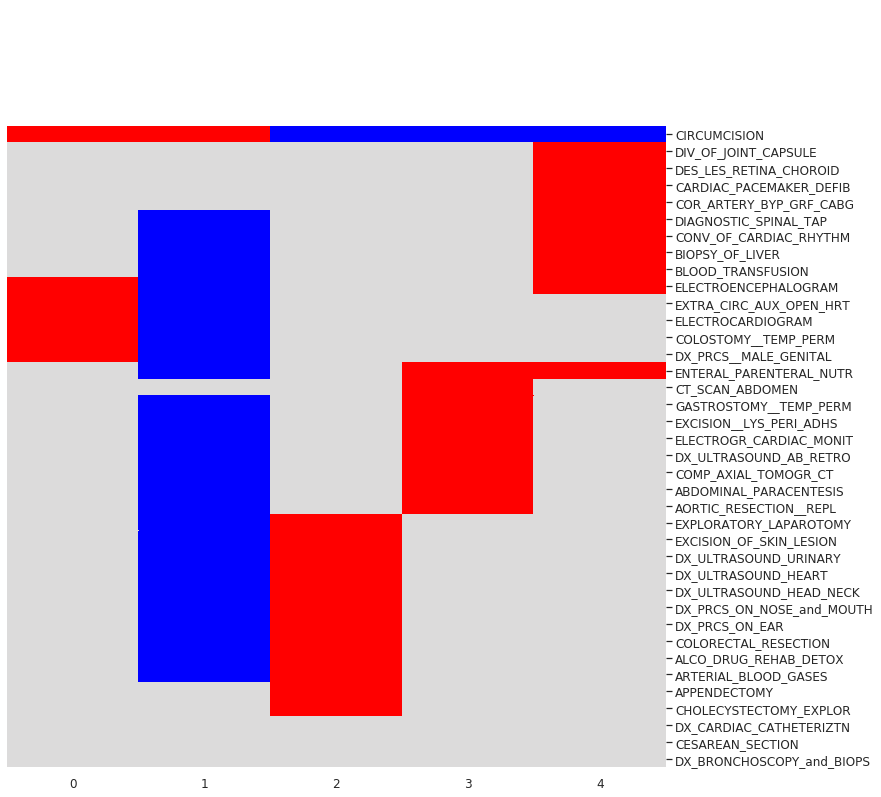

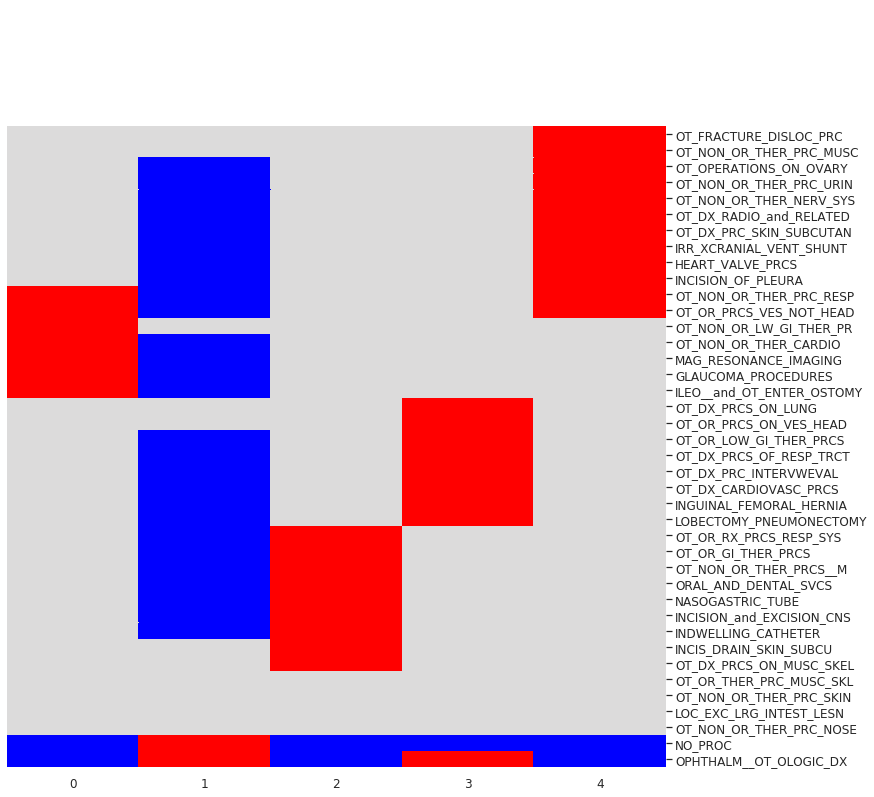

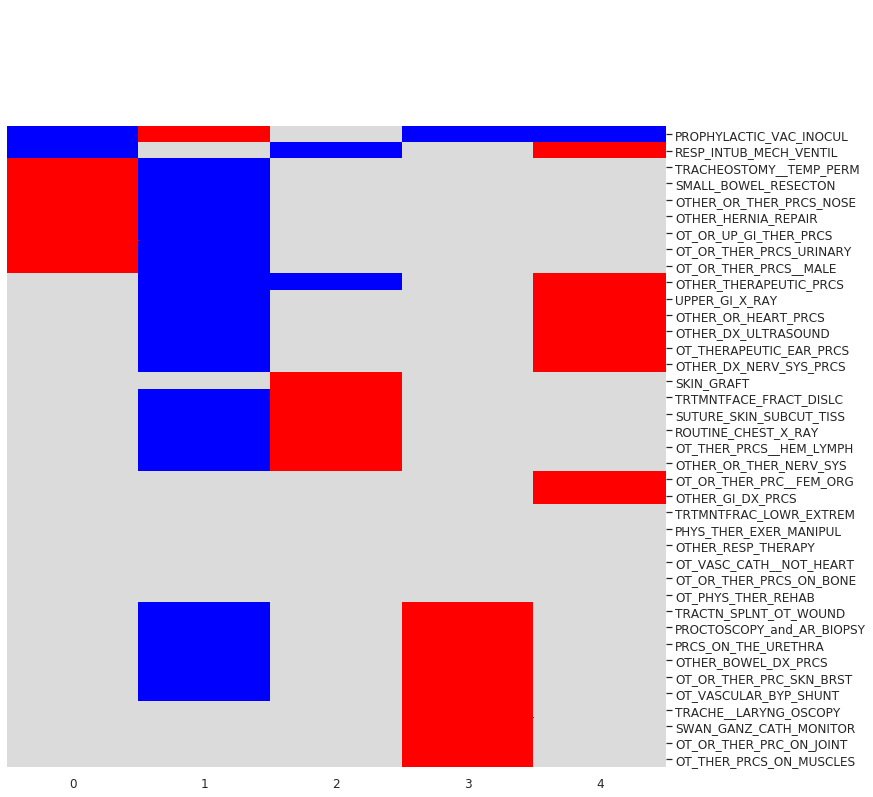

In [215]:
# clustermaps of segments of features.
# Red indicates a given feature has significant positive log ordds ratio to a given cluster, 
# light purple no significance, blue significant negative.

sns.set(font_scale=1.1)
# racial features
plotclustmap(feat_table[:,61:69].T, None, np.array(new_feat)[61:69], None, None)
plt.yticks(rotation=0) 
# county features
plotclustmap(feat_table[:,np.r_[0:8,74]].T,None, np.array(new_feat)[np.r_[0:8,74]],None,None)
plt.yticks(rotation=0)

# # # admission features
plotclustmap(feat_table[:,75:80].T,None,np.array(new_feat)[75:80],None,None)
plt.yticks(rotation=0)

# # ER, Low BW,
plotclustmap(feat_table[:,70:72].T,None,np.array(new_feat)[70:72],None,None)
plt.yticks(rotation=0)

# # #disease features
plotclustmap(feat_table[:,80:110].T,None,np.array(new_feat)[80:110],None,None)
plotclustmap(feat_table[:,110:142].T,None,np.array(new_feat)[110:142],None,None)

# # # procedure features
plotclustmap(feat_table[:,142:180].T,None,np.array(new_feat)[142:180],None,None)
plotclustmap(feat_table[:,180:220].T,None,np.array(new_feat)[180:220],None,None)
plotclustmap(feat_table[:,220:].T,None,np.array(new_feat)[220:],None,None)

# cadre weights and predictibility

In [216]:
weights = np.array(model.weights)[:,1:]
sorted_weights = weights[np.argsort( highcostratio ),:] 
for i in range (sorted_weights.shape[0]):
    posn = pd.Series(sorted_weights[i,:]).nlargest(n=5)
    negn = pd.Series(sorted_weights[i,:]).nsmallest(n=5)
    print('here are top 5 positive values of cadre : {}'.format(i))
    print('here are the names : {}'.format([new_feat[j] for j in posn.index.values]))
    print(posn.values)      
    print('here are top 5 negative values of cadre : {}'.format(i))
    print('here are the names : {}'.format([new_feat[j] for j in negn.index.values]))      
    print(negn.values)
    print ('\n \n' )

here are top 5 positive values of cadre : 0
here are the names : ['Monroe', 'Intrauterine_hypoxia_and_birth_asphyxia', 'Long_Island', 'OT_OR_PRCS_VES_NOT_HEAD', 'Hudson_Valley']
[3.2859157  3.00387169 2.66767268 2.55181837 2.32236424]
here are top 5 negative values of cadre : 0
here are the names : ['ELECTROCARDIOGRAM', 'OT_OR_THER_PRCS__MALE', 'NO_PROC', 'Montgomery', 'PROPHYLACTIC_VAC_INOCUL']
[-4.77541042 -2.98164138 -2.91899435 -2.31743312 -2.30285807]

 

here are top 5 positive values of cadre : 1
here are the names : ['ENTERAL_PARENTERAL_NUTR', 'OT_VASC_CATH__NOT_HEART', 'Other_perinatal_conditions', 'RESP_INTUB_MECH_VENTIL', 'DIAGNOSTIC_SPINAL_TAP']
[2.16107782 1.97516622 1.80317381 1.62428915 1.58053421]
here are top 5 negative values of cadre : 1
here are the names : ['OPHTHALM__OT_OLOGIC_DX', 'PROPHYLACTIC_VAC_INOCUL', 'NO_PROC', 'CIRCUMCISION', 'Hemolytic_jaundice_and_perinatal_jaundice']
[-1.84828997 -1.59584724 -1.40184481 -1.09850364 -0.88523591]

 

here are top 5 posit

# SBMM

In [217]:
Labels = labTrainB

target = pd.DataFrame(ytrain,columns=['Target'])

cadre = pd.DataFrame(Labels,columns=['Cadre'])

target['Cadre']= cadre['Cadre']

highcostratio = np.array([])
clustpop = np.array([])

for i in range(n_clusters):
    pop = target[target['Cadre']==i]['Target'].shape[0]
    clustpop = np.append(clustpop,pop)
    ratio = np.count_nonzero(target[target['Cadre']==i]['Target'].values)*1.0/pop
    highcostratio= np.append(highcostratio,ratio)
    print(pop,ratio)

22359 0.11856523100317545
12156 0.24555774925962487
25347 0.2899751449875725
7843 0.3624888435547622
25838 0.2941404133446861


In [218]:
print('percent of high cost ratio by SBMM')
print(np.sort(highcostratio).round(2))
print('relative cadre size by SBMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print('Log odds ratio for each cadre by SBMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

percent of high cost ratio by SBMM
[0.12 0.25 0.29 0.29 0.36]
relative cadre size by SBMM
[0.239 0.13  0.271 0.276 0.084]
Log odds ratio for each cadre by SBMM
[-1.12 -0.03  0.28  0.31  0.59]


In [219]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2   

In [220]:
# Calculate log odds ratios for feature vs. cluster, uncorr
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

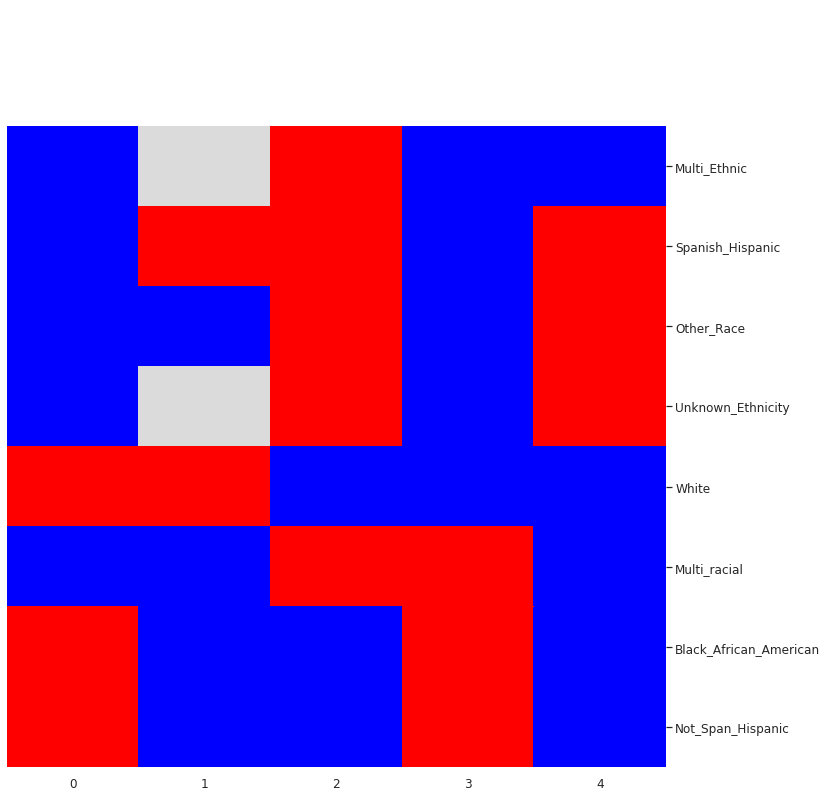

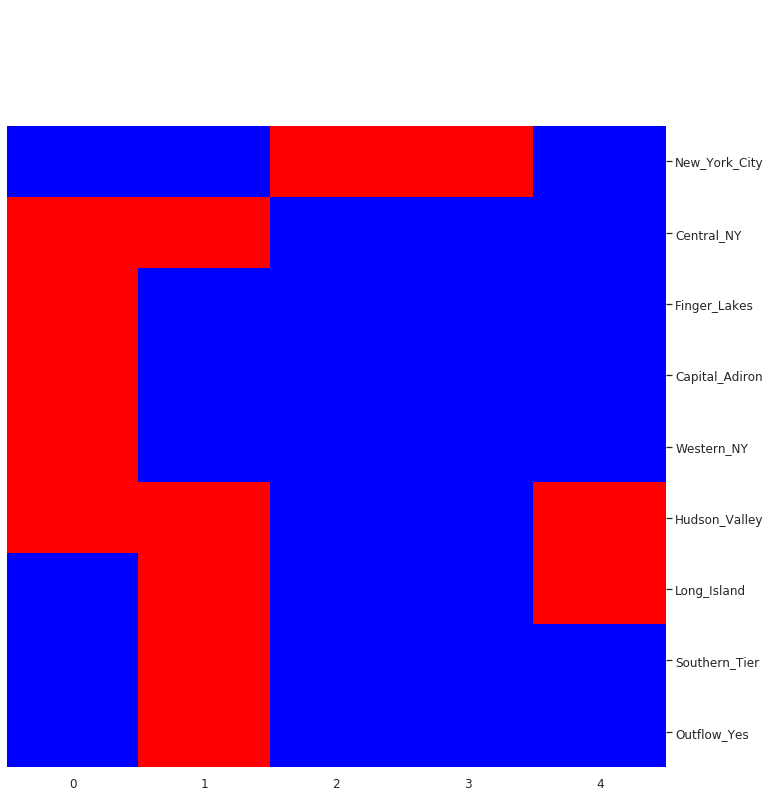

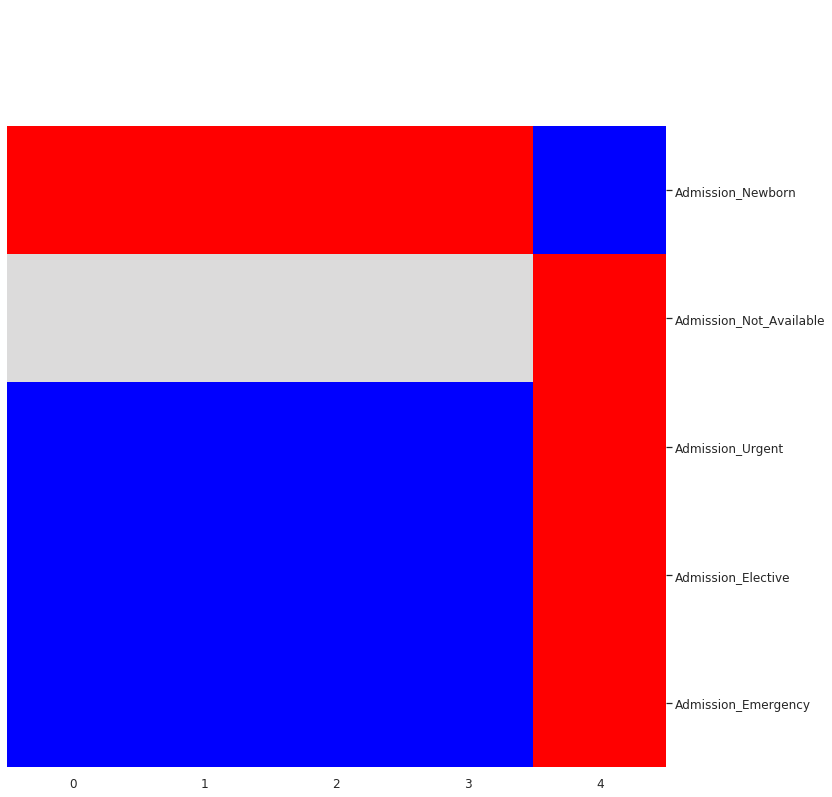

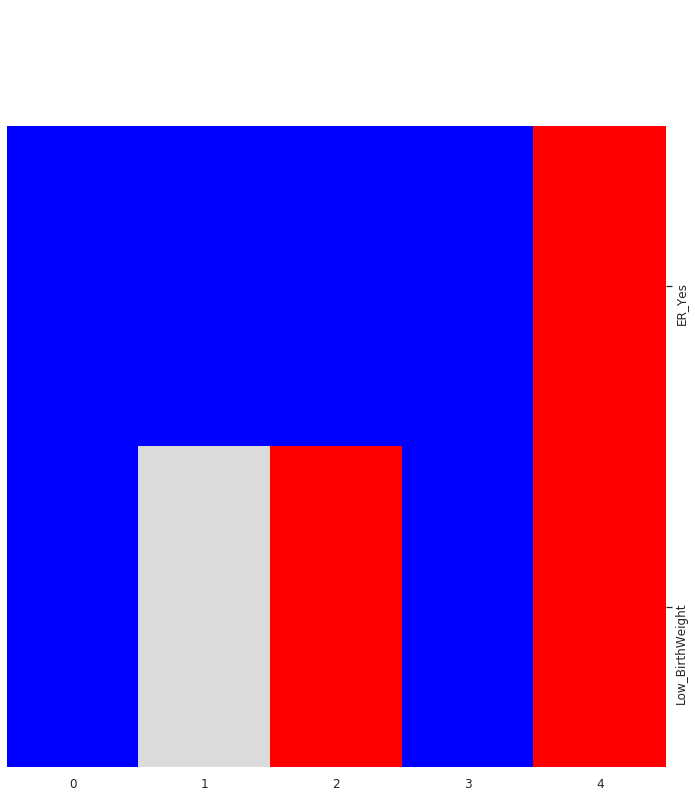

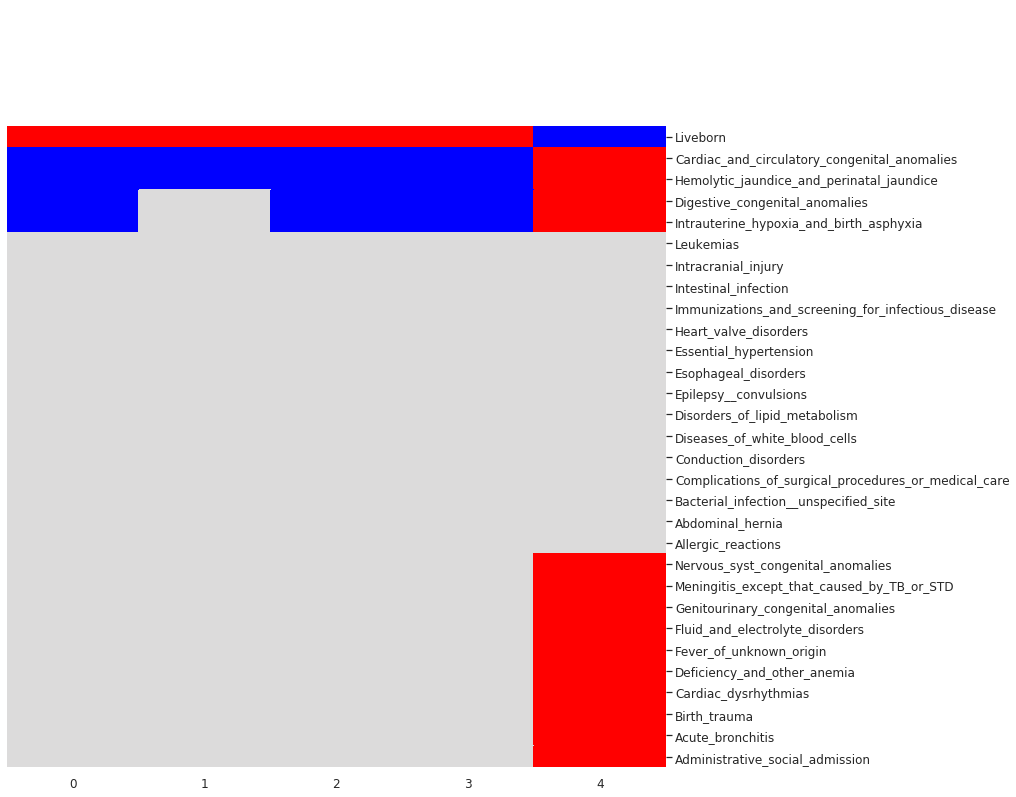

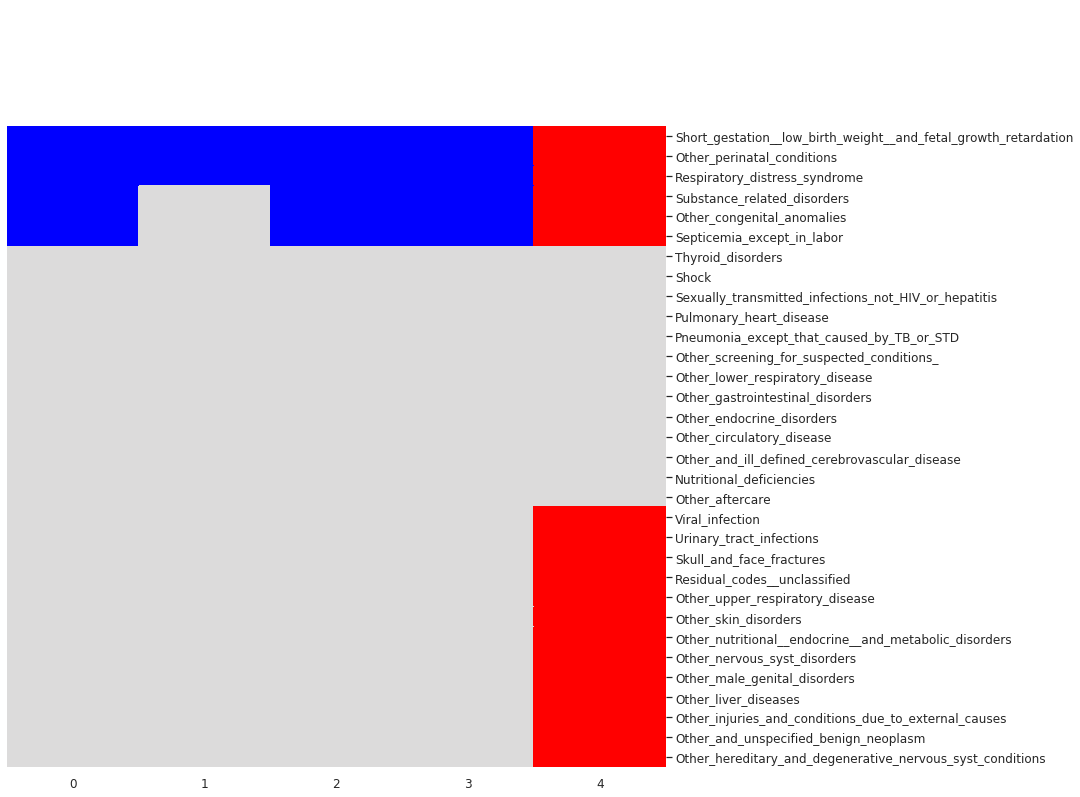

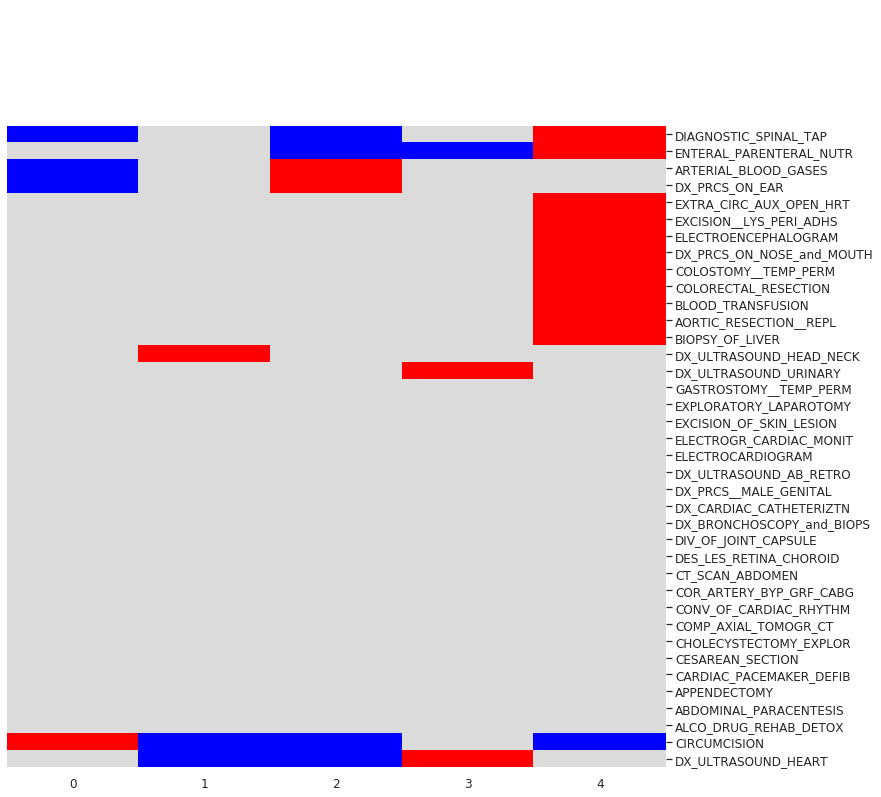

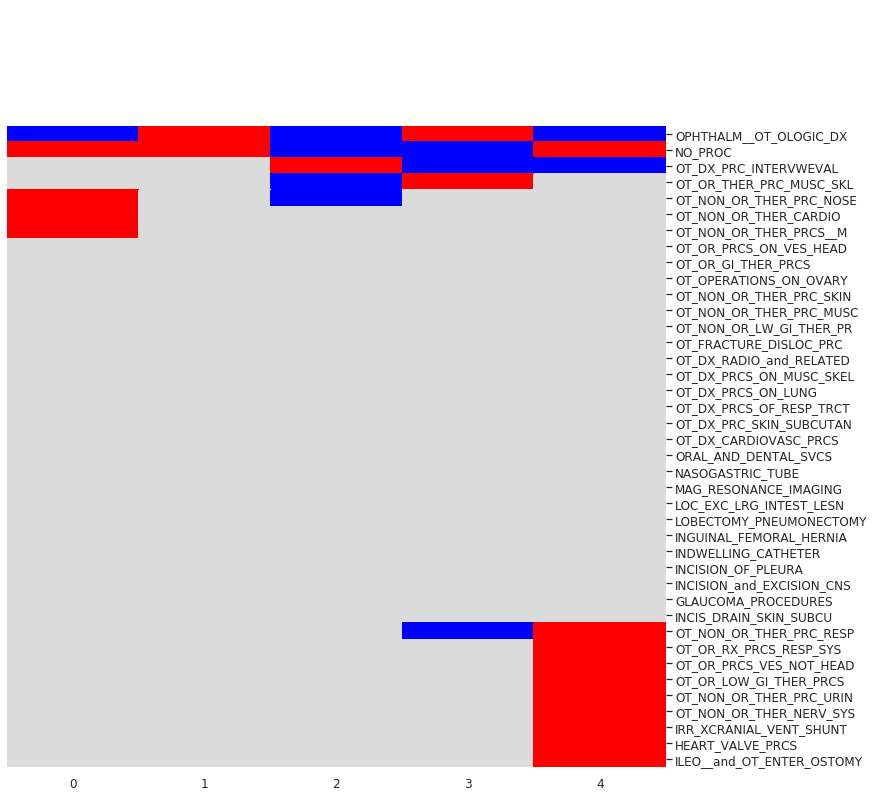

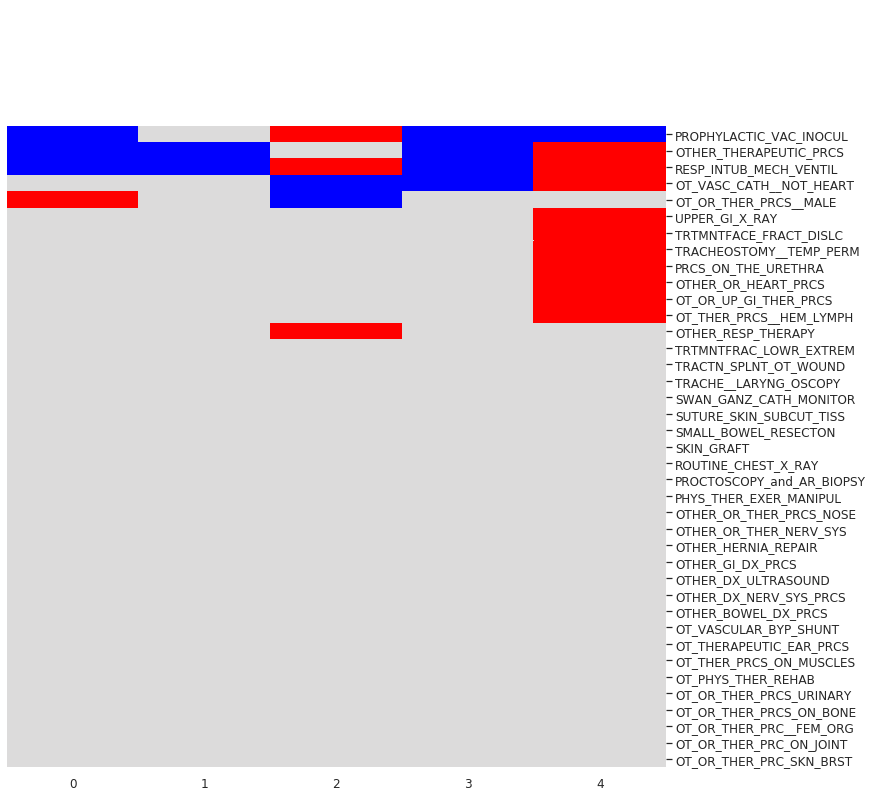

In [221]:
# clustermaps of segments of features.
# Red indicates a given feature has significant positive log ordds ratio to a given cluster, 
# light purple no significance, blue significant negative.

sns.set(font_scale=1.1)
# racial features
plotclustmap(feat_table[:,61:69].T, None, np.array(new_feat)[61:69], None, None)
plt.yticks(rotation=0) 
# county features
plotclustmap(feat_table[:,np.r_[0:8,74]].T,None, np.array(new_feat)[np.r_[0:8,74]],None,None)
plt.yticks(rotation=0)

# # # admission features
plotclustmap(feat_table[:,75:80].T,None,np.array(new_feat)[75:80],None,None)
plt.yticks(rotation=0)

# # ER, Low BW,
plotclustmap(feat_table[:,70:72].T,None,np.array(new_feat)[70:72],None,None)
plt.yticks(rotation=0)

# # #disease features
plotclustmap(feat_table[:,80:110].T,None,np.array(new_feat)[80:110],None,None)
plotclustmap(feat_table[:,110:142].T,None,np.array(new_feat)[110:142],None,None)

# # # procedure features
plotclustmap(feat_table[:,142:180].T,None,np.array(new_feat)[142:180],None,None)
plotclustmap(feat_table[:,180:220].T,None,np.array(new_feat)[180:220],None,None)
plotclustmap(feat_table[:,220:].T,None,np.array(new_feat)[220:],None,None)

# SBMM preditive weights

In [222]:
weights = np.array(modelB.weights)[:,1:]
sorted_weights = weights[np.argsort( highcostratio ),:] 
for i in range (sorted_weights.shape[0]):
    posn = pd.Series(sorted_weights[i,:]).nlargest(n=5)
    negn = pd.Series(sorted_weights[i,:]).nsmallest(n=5)
    print('here are top 5 positive values of cadre : {}'.format(i))
    print('here are the names : {}'.format([new_feat[j] for j in posn.index.values]))
    print(posn.values)      
    print('here are top 5 negative values of cadre : {}'.format(i))
    print('here are the names : {}'.format([new_feat[j] for j in negn.index.values]))      
    print(negn.values)
    print ('\n \n' )

here are top 5 positive values of cadre : 0
here are the names : ['RESP_INTUB_MECH_VENTIL', 'Long_Island', 'Suffolk', 'Rockland', 'Hudson_Valley']
[1.32237948 1.23153551 0.6112313  0.47072251 0.33990769]
here are top 5 negative values of cadre : 0
here are the names : ['Normal_BirthWeight', 'NO_PROC', 'PROPHYLACTIC_VAC_INOCUL', 'CIRCUMCISION', 'Central_NY']
[-1.80227648 -1.34883876 -0.68246079 -0.66092612 -0.12556798]

 

here are top 5 positive values of cadre : 1
here are the names : ['Low_BirthWeight', 'Suffolk', 'Bronx', 'Albany', 'Queens']
[1.62592799 1.42552355 1.25330278 1.16558127 1.15049154]
here are top 5 negative values of cadre : 1
here are the names : ['OPHTHALM__OT_OLOGIC_DX', 'PROPHYLACTIC_VAC_INOCUL', 'NO_PROC', 'CIRCUMCISION', 'Otsego']
[-2.13586272 -2.09192797 -1.97017757 -1.43824487 -1.11973381]

 

here are top 5 positive values of cadre : 2
here are the names : ['Low_BirthWeight', 'RESP_INTUB_MECH_VENTIL', 'OT_VASC_CATH__NOT_HEART', 'ENTERAL_PARENTERAL_NUTR', 'OTHE